In [13]:
from io import BytesIO

import cairo
import IPython.display

In [14]:
from collections import deque
import math

#Helper functions
def add(a,b):
    return [a[0]+b[0],a[1]+b[1]];
def sub(a,b):
    return [a[0]-b[0],a[1]-b[1]];
def norm(a):
    return pow(pow(a[0],2.0)+pow(a[1],2.0),0.5);


def vect_ang(a):
    return math.atan2(-a[1],a[0])
def vect_angl(ang):
    return [math.cos(ang),-math.sin(ang)]
def vect_rotate(a,ang):
    return [a[1]*math.sin(ang)+a[0]*math.cos(ang),-a[0]*math.sin(ang)+a[1]*math.cos(ang)]
def vect_scale(a,s):
    return [a[0]*s,a[1]*s]
def vect_lerp(a,b,s):
    return add(vect_scale(a,1-s),vect_scale(b,s))


def arr_shift(a,amt):
    amt=amt%len(a)
    return a[amt:]+a[0:amt]

In [15]:
import networkx as nx
import matplotlib.pyplot as plt
def expand_graph(G,pos):
    H= nx.MultiGraph()
    new_pos={}
    for n in G.nodes:
        print(G[n])
        adjs= G[n]
        adjList=[]
        print("n:",n,"-------===++===---")
        tot_edges=5.0
#         for adj in adjs:
#             tot_edges+=G.number_of_edges(n,adj)
            
        edge_num=0.0
        for adj in adjs:
            num_edges= G.number_of_edges(n,adj)
            diff= sub(pos[adj],pos[n])
            diff=vect_scale(diff,1.0/norm(diff))
            for i in range(num_edges):
                name=str(n)+":"+str(adj)+"-"+str(i)
                H.add_node(name)
                rotated=rotate(diff,0.2*( float(i)-float(num_edges-1)/2))
                print("rotated:",rotated)
                new_pos[name]= add(pos[n],vect_scale(rotated,0.3))
                edge_num+=1
                
            adjList.append(adj)
            
        print("Huh:",adjList)
        adjList=deque(adjList)
        for i in range(len(adjList)):
            print("prev curr:",adjList[0],":",adjList[1])
            prev=adjList[0]
            curr=adjList[1]
            num_edges= G.number_of_edges(n,prev)
            H.add_edge(str(n)+":"+str(prev)+"-"+str(num_edges-1),str(n)+":"+str(curr)+"-"+str(0))
            for i in range(num_edges-1):
                H.add_edge(str(n)+":"+str(prev)+"-"+str(i),str(n)+":"+str(prev)+"-"+str(i+1))
            
            adjList.rotate(-1)

    
#             H.add_edge(str(n)+":"+str(prev),str(n)+":"+str(curr))
        
    for e in G.edges:
        H.add_edge(str(e[0])+":"+str(e[1])+"-"+str(e[2]),str(e[1])+":"+str(e[0])+"-"+str(e[2]))
    return H,new_pos
        

In [16]:
def draw_neat(G,pos=None):
    if pos is None:
        pos = nx.planar_layout(G)
#     print(pos)
    ax = plt.gca()
    nx.draw_networkx(G, pos,with_labels=True, node_color = 'y', node_size = 100, alpha = 1,font_size=12,font_color="b")
    for e in G.edges:
        num_edges= G.number_of_edges(e[0],e[1])
#         print(num_edges)
#         print("e:",e)
        shift=0.2*( float(num_edges-1)/2-e[2])
        ax.annotate("",
                    xy=pos[e[0]], xycoords='data',
                    xytext=pos[e[1]], textcoords='data',
                    arrowprops=dict(arrowstyle="-", color="0.5",
                                    shrinkA=5, shrinkB=5,
                                    patchA=None, patchB=None,
                                    connectionstyle="arc3,rad=rrr".replace('rrr',str(shift)
                                    ),
                                    ),
                    )
    plt.axis('off')
    plt.show()

In [17]:
class NeatVert:
#     value=0
#     name=""
#     pos=[0,0]
#     color="b"
#     adj=[]
    def __init__(self,value,name,pos):
        self.graph=None
        self.value=value
        self.name=name
        self.pos=pos
        self.edges_data=[]
#         self.edges=[]
#         self.edges_direct=[]
    def put_edge_with_ang(self,edge,ang):
        ang= ang%math.tau
        print("EDGE:",str(edge),"---____----")
        data=EdgeData(edge,edge.get_which(self))
        for i,edge_in in reversed(list(enumerate(self.edges_data))):
            if(edge_in.edge.get_angle_to(self)<ang):
#                 self.edges.insert(i+1,edge);
#                 self.edges_direct.insert(i+1,edge.get_which(self))
                self.edges_data.insert(i+1,data)
                return
#         self.edges.insert(0,edge);
#         self.edges_direct.insert(0,edge.get_which(self))
        self.edges_data.insert(0,data)
    def get_edge_data(self,edge):
        return ([edge_data.edge for edge_data in self.edges_data if edge_data.edge==edge]+[None])[0]
    
    def get_edge_data_index(self,edge):
        return ([i for i in range(len(self.edges_data)) if self.edges_data[i].edge==edge]+[None])[0]
        
    def put_edge(self,edge):
        which= edge.get_which(self)
        self.put_edge_with_ang(edge,edge.get_angle_to(self)) 
    
    def draw(self,ctx,text=True):
        x=self.pos[0]
        y=self.pos[1]
        ctx.set_source_rgba(1, 0.2, 0.2, 1)
        ctx.arc(x,y,0.06,0,math.tau)
        ctx.fill()
        if text:
            ctx.set_source_rgba(0,0,0, 1)
            ctx.select_font_face("Courier", cairo.FONT_SLANT_NORMAL, 
            cairo.FONT_WEIGHT_NORMAL)
            ctx.set_font_size(0.1*ctx.get_matrix().xx/200)
            text=self.name
            (_, _, width, height, _, _) = ctx.text_extents(text) 
            ctx.move_to(x-width/2, y+height/2)
            ctx.show_text(text)
        
        

In [18]:
class NeatEdge:
    def __init__(self,value_a,value_b):
        self.graph=None
        self.value_a=value_a
        self.value_b=value_b
        self.values=[value_a,value_b]
        self.vert_a=None
        self.vert_b=None
        self.verts=[None,None]
        self.angle=None
        self.left_face=None
        self.right_face=None
        self.faces=[None,None]
    def set_graph(self,graph):
        self.graph=graph
        self.vert_a=self.graph.vertdict[self.value_a]
        self.vert_b=self.graph.vertdict[self.value_b]
        self.verts=[self.vert_a,self.vert_b]
        
    def get_which(self,vert):
        if self.value_a==vert.value:
            return 0
        if self.value_b==vert.value:
            return 1
        raise ValueError
        
    def get_other(self,vert):
        if self.value_a==vert.value:
            return self.value_b
        if self.value_b==vert.value:
            return self.value_a
        raise ValueError    
    
    def get_which_face(self,face):
        if self.left_face==face:
            return 0
        if self.right_face==face:
            return 1
        raise ValueError
        
    def get_other_face(self,face):
        if self.left_face==face:
            return self.right_face
        if self.right_face==face:
            return self.left_face
        raise ValueError
  
    
    def get_vert(self,direct):
        return self.graph.vertdict[self.values[direct]]
        
    def get_angle(self,direct):
        if direct==0:
            return self.angle
        elif direct==1:
            return (self.angle+math.pi)%math.tau
    def get_angle_to(self,vert):
        return self.get_angle(self.get_which(vert))
    def __str__(self):
        return "neatEdge{value_a:"+str(self.value_a)+" value_b:"+str(self.value_b)+" angle:"+str(self.angle)+" }"
    def neat_format(self,direct):
        return str(self.values[direct])+"-"+str(self.values[not direct])
    
    def next_edge(self,direct,shift):
        vert=self.graph.vertdict[self.values[direct]]
#         vert.edges_data.index(vert.get_edge_data(self))
        index= (vert.get_edge_data_index(self)+shift)%len(vert.edges_data)
        next_edge=vert.edges_data[index].edge
        return (next_edge.get_which(vert),next_edge);
    
    def generate_faces(self):
#         left face
        if(self.left_face==None):
            self.left_face= Face(self.graph,self,0)
        if(self.right_face==None):
            self.right_face= Face(self.graph,self,1)
        self.faces=[self.left_face,self.right_face]
    
    def draw(self,ctx,width=0.04,colors=(0,0,0,1)):
        lerp_mid=vect_lerp(self.vert_a.pos,self.vert_b.pos,0.5)
        x, y, x1, y1 = self.vert_a.pos[0], self.vert_a.pos[1], lerp_mid[0], lerp_mid[1]
        x2, y2, x3, y3 = lerp_mid[0], lerp_mid[1],self.vert_b.pos[0], self.vert_b.pos[1]
        ctx.move_to(x, y)
        ctx.curve_to(x1, y1, x2, y2, x3, y3)
        ctx.stroke()
        ctx.set_source_rgba(*colors)
        ctx.set_line_width(width)
        ctx.stroke()
        
        

In [113]:
class VertData:
    def __init__(self,vert,in_edges,out_edges):
        self.vert=vert
        self.in_edges=in_edges
        self.out_edges=out_edges
    def copy(self):
        in_edges=[edge for edge in self.in_edges]
        out_edges=[edge for edge in self.out_edges]
        return VertData(self.vert,in_edges,out_edges)
        
    def __len__(self):
        return len(self.in_edges)+len(self.out_edges)
    def get_adj_verts(self):
        adj_verts=[]
        for edge in self.in_edges+self.out_edges:
            adj_verts.append(edge.get_other(self.vert))
        return adj_verts
    
class EdgeData:
    def __init__(self,edge,direct):
        self.edge=edge
        self.direct=direct
    def copy(self):
        return EdgeData(self.edge,self.direct)
    def __str__(self):
        return self.edge.neat_format(self.direct)
    def format(self):
        return self.edge.neat_format(self.direct)
        
class EdgeSet:
    def __init__(self,graph,verts_data,edges_data):
        self.graph=graph
        self.edges_data=edges_data 
        self.edges=[edge_data.edge for edge_data in self.edges_data]
        #edges may or may not necicarially be cyclic
        self.verts_data=verts_data
        self.verts_data_dict={}
        for vert_data in verts_data:
            self.verts_data_dict[vert_data.vert.value]=vert_data
#         for i in range(len(verts)):
#             vert = verts[i]
#             degree=0
#             in_edges=[]
#             out_edges=[]
#             for vert_edge_data in vert.edges_data:
#                 vert_edge=vert_edge_data.edge
#                 edge_data=self.get_edge_data(vert_edge)
#                 if(edge_data!= None):
#                     degree+=1
#                     if(vert_edge.get_which(vert)==edge_data.direct):
#                         out_edges.append(vert_edge)
#                     if(vert_edge.get_which(vert)!=edge_data.direct):
#                         in_edges.append(vert_edge)
#             vert_data=VertData(vert,in_edges,out_edges)
#             if(len(vert_data)>0):
#                 self.verts_data_dict[vert.value]=vert_data
#                 self.verts_data.append(vert_data)
    def get_edge_data(self,edge):
        return ([edge_data for edge_data in self.edges_data if edge_data.edge==edge]+[None])[0]
    
    def get_edge_data_index(self,edge):
        return ([i for i in range(len(self.edges_data)) if self.edges_data[i].edge==edge]+[None])[0]
    
    def get_vert_data(self,vert):
        return ([vert_data for vert_data in self.verts_data if vert_data.vert==vert]+[None])[0]
    
    def get_vert_data_index(self,vert):
        return ([i for i in range(len(self.verts_data)) if self.verts_data[i].vert==vert]+[None])[0]
    def copy(self):
        verts_data=[vert_data.copy() for vert_data in self.verts_data] # Shallow copy
        edges_data=[edge_data.copy() for edge_data in self.edges_data]
        return EdgeSet(self.graph,verts_data,edges_data)
    
    def merge_data(self,edgeSet):
        verts_data=[vert_data.copy() for vert_data in self.verts_data] # Shallow copy
        def get_vert_data(vert):
            return ([vert_data for vert_data in verts_data if vert_data.vert==vert]+[None])[0]
        edges_data=[edge_data.copy() for edge_data in self.edges_data]
        def get_edge_data(edge):
            return ([edge_data for edge_data in edges_data if edge_data.edge==edge]+[None])[0]
        
        verts=[vert_data.vert for vert_data in self.verts_data]
        edges=[edge_data.edge for edge_data in self.edges_data]
        for vert_data in edgeSet.verts_data:
            if(not vert_data.vert in verts):
                verts_data.append(vert_data.copy()) # Just add all the verts
                verts.append(vert_data.vert)
                
        for edge_data in edgeSet.edges_data:
            if(edge_data.edge in edges):
                edges_data.remove(get_edge_data(edge_data.edge))
                edges.remove(edge_data.edge)
            else:
                edges_data.append(edge_data)
                edges.append(edge_data.edge)
        return (self.graph,verts,verts_data,edges_data)
    
    def merge(self,edgeSet):
        graph, verts,verts_data,edges_data=self.merge_data(edgeSet)
        return EdgeSet(graph,verts_data,edges_data)
    
    def __eq__(self,other):
#         if not type(self) is type(other):
#             return False
        if not isinstance(other,EdgeSet):
            return False
        if self.graph != other.graph:
            return False
        if len(self.edges) != len(other.edges):
            return False
        for edge in self.edges:
            if not edge in other.edges:
#                 print("edge "+str(edge)+" not in")
                return False
        return True
    def __str__(self):
        name= "EdgeSet{"
        for edge_data in self.edges_data:
            name+=" "+str(edge_data)
        name+="}"
        return name
            
class CycleSet(EdgeSet):
    def __init__(self,graph,verts,edges_data,faces):
        self.edges_data=edges_data
        verts_data=[]
        #generate verts_data
        for i in range(len(verts)):
            vert = verts[i]
            degree=0
            in_edges=[]
            out_edges=[]
            for vert_edge_data in vert.edges_data:
                vert_edge=vert_edge_data.edge
                edge_data=self.get_edge_data(vert_edge)
                if(edge_data!= None):
                    degree+=1
                    if(vert_edge.get_which(vert)==edge_data.direct):
                        out_edges.append(vert_edge)
                    if(vert_edge.get_which(vert)!=edge_data.direct):
                        in_edges.append(vert_edge)
            vert_data=VertData(vert,in_edges,out_edges)
            if(len(vert_data)>0):
                verts_data.append(vert_data)
        super().__init__(graph,verts_data,edges_data)
        valid=True
        for i in range(len(self.verts_data)):
            if len(self.verts_data[i])!=2:
                raise ValueError
                valid=False
                
        if faces==None:
            #Generate faces
            internal_faces=[self.edges_data[0].edge.left_face]
            def complete(inter_faces):
                all_good=True
                for inter_face in inter_faces:
                    for edge in inter_face.edges:
                        edge_good=False
                        if edge in [edge_data.edge for edge_data in self.edges_data]:
                            edge_good=True
                        else:
                            other_face= edge.get_other_face(inter_face)
                            if other_face in internal_faces:
                                edge_good=True
                            else:
                                edge_good=False
                                inter_faces.append(other_face)
                        if not edge_good:
                            all_good=False
            complete(internal_faces)
            faces=self.fix_faces(internal_faces)
        self.faces=faces
   
       
    def fix_faces(self,in_faces):
        def is_valid():
            num_inc=0
            for this_inc_face in in_faces:
                num_inc+=1
            valid=num_inc<= len(self.graph.faces)//2
            if len(in_faces)%2==0:
                if num_inc ==len(self.graph.faces)//2:
                    valid= self.graph.faces[0] in in_faces
            return valid
        faces=[]
        if not is_valid():
            for face in self.graph.faces:
                if not face in in_faces:
                    faces.append(face)
        else:
            faces= in_faces
        return faces
    
    def gen_independent_cycles_data(self):
        copy=self.copy()
        cycles_verts=[]
#         def num_visited(): # The total number of verts put into the array
#             return sum([len(a) for a in cycles_verts])
        while len(copy.verts_data)>0:
            cycle_verts=[]
            start_vert=copy.verts_data[0]
            prev_vert=start_vert
            curr_vert=copy.verts_data_dict[start_vert.get_adj_verts()[0]]
#             print("prev_vert:"+str(prev_vert.vert.value))
#             print("curr_vert:"+str(curr_vert.vert.value))
            while True:
#                 shift moving vert
                cycle_verts.append(prev_vert.vert)
                
                next_vert=None
                for adj_vert in curr_vert.get_adj_verts():
#                     print("Adj_vert:"+str(adj_vert))
                    if(copy.verts_data_dict[adj_vert]!=prev_vert):
                        if(next_vert!=None):
                            # There should only be 1 adjacent vert that isnt the prev_vert
                            raise ValueError
                        next_vert=copy.verts_data_dict[adj_vert]
                if next_vert==None:
                    #There should be 1 and only 1 adj vert that isnt the prev_vert
                    raise ValueError
                copy.verts_data.remove(prev_vert)
                prev_vert=curr_vert
                curr_vert=next_vert
#                 print("--> prev_vert:"+str(prev_vert.vert.value))
#                 print("--> curr_vert:"+str(curr_vert.vert.value))
                if(prev_vert==start_vert): # If looped back around
                    break
            cycles_verts.append(cycle_verts)
        return cycles_verts
    
    def gen_independent_cycles(self):
        cycles_verts=self.gen_independent_cycles_data()
#         print(str([str(cycle_verts) for cycle_verts in cycles_verts]))
        indep_cycles=[]
        for cycle_verts in cycles_verts:
#             print([str(cycle_vert.value) for cycle_vert in cycle_verts])
            indep_cycles.append(EvenCycle(self.graph,[cycle_vert.value for cycle_vert in cycle_verts]))
        return indep_cycles
    
    def merge(self,cycleSet):
        faces=[face for face in self.faces]
        for face in cycleSet.faces:
            if(face in faces):
                faces.remove(face)
            else:
                faces.append(face)
        graph, verts,verts_data,edges_data=self.merge_data(cycleSet)
        return CycleSet(graph,verts,edges_data,faces)
    def copy(self):
        verts=[vert_data.vert for vert_data in self.verts_data] # Shallow copy
        edges_data=[edge_data.copy() for edge_data in self.edges_data]
        faces= self.faces.copy()
        return CycleSet(self.graph,verts,edges_data,faces)
    def __add__(self,cycleSet):
        return self.merge(cycleSet)
    
    def is_saturated(self):
        for vert in self.graph.verts:
            if self.get_vert_data(vert)==None:
                return False
        return True
    
    def is_covering(self):
        saturated= self.is_saturated()
        if not saturated:
            return False
        indep_cycles= self.gen_independent_cycles_data()
        for elem in indep_cycles:
            if len(elem)%2==1:
                return False
        return True
    
    def make_covering(self):
        return CoveringCycleSet(self.graph,[vert_data.vert for vert_data in self.verts_data],self.edges_data,self.faces)
        
    def __str__(self):
        name= "CycleSet{"
        for edge_data in self.edges_data:
            name+=" "+str(edge_data)
        name+="|"
        for face in self.faces:
            name+=" "+str(face)
        name+=":"
        name+= str(len(self.faces))
        name+="}"
        
        return name
    
    def draw(self,ctx):
        for edge_data in self.edges_data:
            edge_data.edge.draw(ctx,width=0.06,colors=(0.4,0.4,1,1))
        self.edges_data[0].edge.draw(ctx,width=0.06,colors=(0.4,0.4,1,1))
        
class CoveringCycleSet(CycleSet):
    def __init__(self,graph,verts,edges_data,faces):
        super().__init__(graph,verts,edges_data,faces)
        if not isinstance(self.graph,CubicGraph):
            raise ValueError
        if not self.is_covering():
            raise ValueError
        self.neat_cycles=self.gen_independent_cycles()
    def __str__(self):
        name= "CoveringCycle{"
        for edge_data in self.edges_data:
            name+=" "+str(edge_data)
        name+="|"
        for neat_cycle in self.neat_cycles:
            name+=" "+str(neat_cycle)
        name+=":"
        name+= str(len(self.neat_cycles))
        name+="}"
        return name
    def get_next_vert(self,curr_vert,prev_vert,shift_parities):
        next_vert=None
        for adj_vert in curr_vert.get_adj_verts():
#                     print("Adj_vert:"+str(adj_vert))
                    if(copy.verts_data_dict[adj_vert]!=prev_vert):
                        if(next_vert!=None):
                            # There should only be 1 adjacent vert that isnt the prev_vert
                            raise ValueError
                        next_vert=copy.verts_data_dict[adj_vert]
        return next_vert
    
    def get_adjacent_cycles(self,shift_parities):
        copy=self.copy()
        cycles_verts=[]
#         def num_visited(): # The total number of verts put into the array
#             return sum([len(a) for a in cycles_verts])
        while len(copy.verts_data)>0:
            cycle_verts=[]
            start_vert=copy.verts_data[0]
            prev_vert=start_vert
            curr_vert=copy.verts_data_dict[start_vert.get_adj_verts()[0]]
#             print("prev_vert:"+str(prev_vert.vert.value))
#             print("curr_vert:"+str(curr_vert.vert.value))
            while True:
#                 shift moving vert
                cycle_verts.append(prev_vert.vert)
                
                next_vert=self.get_next_vert(curr_vert,prev_vert,shift_parites)
                
                if next_vert==None:
                    #There should be 1 and only 1 adj vert that isnt the prev_vert
                    raise ValueError
                copy.verts_data.remove(prev_vert)
                prev_vert=curr_vert
                curr_vert=next_vert
#                 print("--> prev_vert:"+str(prev_vert.vert.value))
#                 print("--> curr_vert:"+str(curr_vert.vert.value))
                if(prev_vert==start_vert): # If looped back around
                    break
            cycles_verts.append(cycle_verts)
        
        ;
#     def get_shift_relative(self, other):
#         if other
        
class NeatCycle(CycleSet):
    def __init__(self,graph,vert_values,faces=None):
        self.graph= graph
        self.verts=[]
        self.edges_data=[]
        if len(vert_values)>1:
            vert_deque= deque(vert_values)
            for i in range(len(vert_values)):
                prev=vert_deque[0]
                curr=vert_deque[1]
    #             print(prev)
                if(prev in graph.vertdict):
                    self.verts.append(graph.vertdict[prev])
                else:
                    raise ValueError
                if(not curr in graph.vertdict):
                    raise ValueError
                if((prev,curr) in graph.edgedict): 
                    edge_tween=graph.edgedict[(prev,curr)]
                    self.edges_data.append(EdgeData(edge_tween,edge_tween.get_which(graph.vertdict[prev])))
                else:
                    raise ValueError
                vert_deque.rotate(-1)
        super().__init__(graph,self.verts,self.edges_data,faces)
    def copy(self):
        return NeatCycle(self.graph,[vert.value for vert in self.verts],self.faces.copy())
    def __str__(self):
        name= "NeatCycle{"
        for edge_data in self.edges_data:
            name+=" "+str(edge_data)
#         name+="|"
#         for face in self.faces:
#             name+=" "+str(face)
        name+=":"
        name+= str(len(self.faces))
        name+="}"
        return name
    def make_even(self):
        if len(self.verts)%2!=0:
            raise ValueError
        self.__class__=EvenCycle
        return self
class EvenCycle(NeatCycle):
    def __init__(self,graph,vert_values,faces=None):
        super().__init__(graph,vert_values,faces)
        if len(self.verts)%2!=0:
            raise ValueError
        
    def shift(self,amount):
        self.verts=arr_shift(self.verts,amount)
        self.edges_data=arr_shift(self.edges_data,amount)
    def get_shift_amt(self,other):
        if other != self:
            return None
        return other.verts.index(self.verts[0])
    
    def get_shift_pairity(self,other):
        return self.get_shift_amt(other)%2
    
    def __str__(self):
        name= "EvenCycle{"
        for edge_data in self.edges_data:
            name+=" "+str(edge_data)
#         name+="|"
#         for face in self.faces:
#             name+=" "+str(face)
        name+=":"
        name+= str(len(self.faces))
        name+="}"
        return name
    
class EmptyCycle(NeatCycle):
    def __init__(self,graph,full=False):
        if full:
            super().__init__(graph,[],graph.faces)
        else:
            super().__init__(graph,[],[])
        
        
class Face(NeatCycle):
    def __init__(self,graph,edge,facing):# facing- 0-> left, 1 -> right
        vert_values=[]
        edges=[]
        directs=[]
        moving_edge=edge
        direct=facing
        while True:
            edges.append(moving_edge)
            directs.append(direct)
            vert_values.append(moving_edge.values[direct])
#                 print(moving_edge.values[direct])
#             print(moving_edge.neat_format(direct))
#             print(direct)
            direct,moving_edge=moving_edge.next_edge(not direct,1)
            if moving_edge==edge:
                break
        super().__init__(graph,vert_values,[self])
        for i in range(len(edges)):
            if(directs[i]==0):
                edges[i].left_face=self
            else:
                edges[i].right_face=self
    def __str__(self):
        name= "Face{"
        for edge_data in self.edges_data:
            name+=" "+str(edge_data)
        name+="}"
        return name
    
#     def __str__(self):
#         text="neatCycle{";
#         for vert in self.verts:
#             text+="-"+str(vert.value)
#         text+="}"
#         return text
    

In [114]:
class NeatGraph:
#     verts=[]
    def __init__(self):
        self.verts=[]
        self.vertdict={}
        self.verts_data=[]
        self.faces=[]
        self.edges=[]
        self.edgedict={}     
    def get_edge(self,val_a,val_b):
        edge= self.edgedict[(val_a,val_b)]
        return edge.get_which(self.vertdict[val_a]),edge
    def add_vert(self,vert):
        self.graph=self
        self.verts.append(vert)
        self.vertdict[vert.value]=vert
        self.verts_data.append(VertData(vert,[],[]))
        
    def get_vert_data(self,vert):
        return ([vert_data for vert_data in self.verts_data if vert_data.vert==vert]+[None])[0]
    
    def add_edge(self,edge):
        edge.set_graph(self)
        self.edges.append(edge)
        edge.angle=(vect_ang(sub(self.verts[edge.value_a].pos,self.verts[edge.value_b].pos))+math.tau)%math.tau
        self.verts[edge.value_a].put_edge(edge)
        self.verts[edge.value_b].put_edge(edge)
        self.edgedict[(edge.value_a,edge.value_b)]=edge
        self.edgedict[(edge.value_b,edge.value_a)]=edge
        self.get_vert_data(edge.vert_a).out_edges.append(edge)
        self.get_vert_data(edge.vert_b).in_edges.append(edge)
    def add_face(self,face):
        if not face in self.faces:
            self.faces.append(face)
        
    def generate_faces(self):
        for edge in self.edges:
            edge.generate_faces()
            self.add_face(edge.left_face)
            self.add_face(edge.right_face)
            
    def cycles_iterator(self): #Generates all the unique cycles on the graph -> generator
        # If the faces of self get changed halfway through, its basically fucked
        if(len(self.faces)==0):
            self.generate_faces()
        inc_faces=[False]*len(self.faces)
        saved_inc_faces=inc_faces
        cycle=EmptyCycle(self)
        
        def next_cycle():
            store_inc_faces=inc_faces.copy()
            index_of_first_false=0
            while store_inc_faces[index_of_first_false]:
                store_inc_faces[index_of_first_false]=False
                index_of_first_false+=1
                if(index_of_first_false >= len(store_inc_faces)):
                    return None
                    
            if(index_of_first_false < len(store_inc_faces)):
                store_inc_faces[index_of_first_false]=True
            else:
                return None
            return store_inc_faces
        def cycle_valid(this_inc_faces):
            num_inc=0
            for this_inc_face in this_inc_faces:
                if this_inc_face:
                    num_inc+=1
            valid=num_inc<= len(self.faces)//2
            if len(self.faces)%2==0:
                if num_inc ==len(self.faces)//2:
#                     print("EVEN!"+str(this_inc_faces[0])+" /"+str(num_inc))
                    valid= this_inc_faces[0]
#             print(str(num_inc)+"Valid?:"+str(valid)+",  "+str(this_inc_faces))
            return valid
        
        def update_cycle(this_cycle,prev_inc_faces,next_inc_faces):
            if( len(prev_inc_faces)!=len(next_inc_faces)):
                raise ValueError
            for (prev_inc_face,next_inc_face,face_cycle) in zip(prev_inc_faces,next_inc_faces,self.faces):
                if prev_inc_face!=next_inc_face:
                    #merge with facecycle
                    this_cycle=this_cycle+face_cycle
            return this_cycle.copy()
        
        while True:
#             print("------_____-----|")
            gen_next_inc_faces = next_cycle()
            if gen_next_inc_faces == None:
                return
            inc_faces= gen_next_inc_faces
            if not cycle_valid(inc_faces):
                continue
            #if our current inc_faces is valid, we can yield it
            #inc to our next cycl
            cycle=update_cycle(cycle,saved_inc_faces,gen_next_inc_faces)
            yield cycle.copy()
            saved_inc_faces= gen_next_inc_faces.copy()
            cycle_faces=[]
            for face in self.faces:
                if face in cycle.faces:
                    cycle_faces.append(True)
                else:
                    cycle_faces.append(False)
#             print("::"+str(cycle_faces)+"  ,  "+str(saved_inc_faces))
    
    def get_nx_graph(self):
        G= nx.MultiGraph()
        pos={}
        for vert in self.verts:
            G.add_node(vert.value)
            pos[vert.value]=vert.pos
        for edge in self.edges:
            G.add_edge(edge.value_a,edge.value_b)
            
        return G,pos
    def draw_content(self,ctx,objects=[],text=True):
        ctx.set_line_width(0.04)
        for edge in self.edges:
            edge.draw(ctx)
        for obj in objects:
            obj.draw(ctx)
        for vert in self.verts:
            vert.draw(ctx,text)
    def draw_graph(self,objects=[],scale=300,text=True):
        svgio = BytesIO()
        with cairo.SVGSurface(svgio, scale, scale) as surface:
            context = cairo.Context(surface)
            context.translate(25,25)
            context.scale(scale-50, scale-50)
            self.draw_content(context,objects,text)
#             x, y, x1, y1 = 0.1, 0.5, 0.4, 0.9
#             x2, y2, x3, y3 = 0.6, 0.1, 0.9, 0.5
#             context.set_source_rgba(0,0,0, 1)
#             context.set_line_width(0.04)
#             context.move_to(x, y)
#             context.curve_to(x1, y1, x2, y2, x3, y3)
#             context.stroke()
        return IPython.display.SVG(data=svgio.getvalue())

In [115]:
class CoveringTriplet:
    def __init__(self,cov_cycle_a,cov_cycle_b,cov_cycle_c):
        self.cov_cycle_a=cov_cycle_a
        self.cov_cycle_b=cov_cycle_b
        self.cov_cycle_c=cov_cycle_c
        self.cycles=[cov_cycle_a,cov_cycle_b,cov_cycle_c]
        
class CoveringCycleData:
    def __init__(self,covering_cycle):
        self.covering_cycle=covering_cycle
        self.covering_triplets=[]

class CubicGraph(NeatGraph):
    def __init__(self):
        super().__init__()
        self.covering_cycles=[]
        self.covering_data=[]
        
    def get_first_covering(self):
        for cycleset in self.cycles_iterator():
            if cycleset.is_covering():
                return cycleset.make_covering()
        return None
    
    def validate(self):
        for vert_data in self.verts_data:
            if len(vert_data)!=3:
                return False
        return True
    
    def gen_covering_data(self):
        if not self.validate():
            raise ValueError
        first_covering=self.get_first_covering()
        self.covering_cycles.append(first_covering)
        return first_covering
        print(str(first_covering))

        

EDGE: neatEdge{value_a:0 value_b:1 angle:1.5707963267948966 } ---____----
EDGE: neatEdge{value_a:0 value_b:1 angle:1.5707963267948966 } ---____----
EDGE: neatEdge{value_a:1 value_b:3 angle:3.141592653589793 } ---____----
EDGE: neatEdge{value_a:1 value_b:3 angle:3.141592653589793 } ---____----
EDGE: neatEdge{value_a:2 value_b:3 angle:1.5707963267948966 } ---____----
EDGE: neatEdge{value_a:2 value_b:3 angle:1.5707963267948966 } ---____----
EDGE: neatEdge{value_a:0 value_b:2 angle:3.141592653589793 } ---____----
EDGE: neatEdge{value_a:0 value_b:2 angle:3.141592653589793 } ---____----
EDGE: neatEdge{value_a:4 value_b:5 angle:1.5707963267948966 } ---____----
EDGE: neatEdge{value_a:4 value_b:5 angle:1.5707963267948966 } ---____----
EDGE: neatEdge{value_a:5 value_b:7 angle:3.141592653589793 } ---____----
EDGE: neatEdge{value_a:5 value_b:7 angle:3.141592653589793 } ---____----
EDGE: neatEdge{value_a:7 value_b:6 angle:4.71238898038469 } ---____----
EDGE: neatEdge{value_a:7 value_b:6 angle:4.712

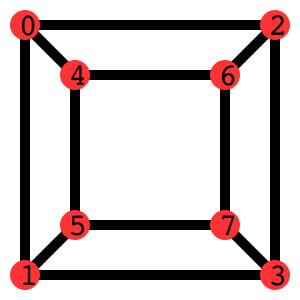

In [116]:
neat= CubicGraph()
neat.add_vert(NeatVert(0,"0",[0,0]))
neat.add_vert(NeatVert(1,"1",[0,1]))
neat.add_vert(NeatVert(2,"2",[1,0]))
neat.add_vert(NeatVert(3,"3",[1,1]))

neat.add_vert(NeatVert(4,"4",[0+0.2,0+0.2]))
neat.add_vert(NeatVert(5,"5",[0+0.2,1-0.2]))
neat.add_vert(NeatVert(6,"6",[1-0.2,0+0.2]))
neat.add_vert(NeatVert(7,"7",[1-0.2,1-0.2]))
for e in [[0,1],[1,3],[2,3],[0,2],[4,5],[5,7],[7,6],[4,6],[0,4],[1,5],[7,3],[6,2]]:
    neat.add_edge(NeatEdge(*e))
    
cycle_set = neat.gen_covering_data()
neat.draw_graph()

In [117]:
covering_set=cycle_set.make_covering()
print(str(covering_set))

CoveringCycle{ 3-7 7-6 6-2 3-2 1-0 0-4 4-5 5-1| EvenCycle{ 2-6 6-7 7-3 3-2:1} EvenCycle{ 1-5 5-4 4-0 0-1:1}:2}


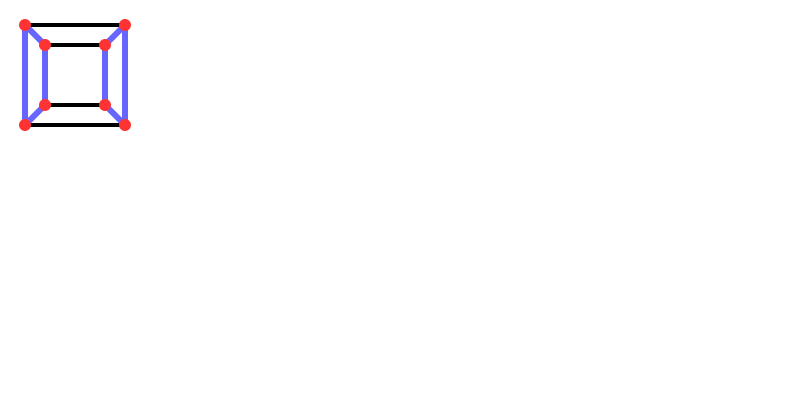

In [118]:
from ipywidgets import widgets, HBox
good_sets=neat.covering_cycles
# for cycleset in neat.cycles_iterator():
#     if cycleset.is_covering():
#         print(cycleset)
# #         neat.draw_graph([cycleset])
#         good_sets.append(cycleset)

# hbox = HBox([neat.draw_graph([good_set],scale=300) for good_set in good_sets])
# display(hbox)
# display(*[neat.draw_graph([good_set],scale=150,text=False) for good_set in good_sets])
scale=150
text=False
columns=5
svgio = BytesIO()
with cairo.SVGSurface(svgio, 800, 400) as surface:
    context = cairo.Context(surface)
    context.translate(25,25)
    context.scale(scale-50, scale-50)
    for i,good_set in enumerate(good_sets):
        context.save()
        context.translate((i%columns)*1.3,(i//columns)*1.3)
        neat.draw_content(context,[good_set],text)
        context.restore()
        
IPython.display.SVG(data=svgio.getvalue())

In [122]:
even1=neat.faces[0].copy().make_even();
even2=neat.faces[0].copy().make_even();
even1.shift(-1)
print(even1)
print(even2)
print(even2.get_shift_pairity(even1))

EvenCycle{ 2-0 0-1 1-3 3-2:1}
EvenCycle{ 0-1 1-3 3-2 2-0:1}
1


In [88]:
neat_cycle.shift(1)
print(neat_cycle)

NeatCycle{ 6-7 7-3 3-2 2-6:1}


In [90]:
c1= neat.faces[0]
c2= neat.faces[0]+neat.faces[1]+neat.faces[1]
print(c1==c2)

True


In [68]:
EdgeSet

__main__.EdgeSet

In [70]:
isinstance(c1,EdgeSet)

True

In [105]:
for face in neat.faces:
    print(face)
    for vert_data in face.verts_data:
        print(str(vert_data.out_edges[0])) 

Face{ 0-1 1-3 3-2 2-0}
neatEdge{value_a:0 value_b:1 angle:1.5707963267948966 }
neatEdge{value_a:1 value_b:3 angle:3.141592653589793 }
neatEdge{value_a:2 value_b:3 angle:1.5707963267948966 }
neatEdge{value_a:0 value_b:2 angle:3.141592653589793 }
Face{ 1-0 0-4 4-5 5-1}
neatEdge{value_a:0 value_b:1 angle:1.5707963267948966 }
neatEdge{value_a:0 value_b:4 angle:2.356194490192344 }
neatEdge{value_a:4 value_b:5 angle:1.5707963267948966 }
neatEdge{value_a:1 value_b:5 angle:3.926990816987241 }
Face{ 3-1 1-5 5-7 7-3}
neatEdge{value_a:1 value_b:3 angle:3.141592653589793 }
neatEdge{value_a:1 value_b:5 angle:3.926990816987241 }
neatEdge{value_a:5 value_b:7 angle:3.141592653589793 }
neatEdge{value_a:7 value_b:3 angle:2.356194490192344 }
Face{ 2-3 3-7 7-6 6-2}
neatEdge{value_a:2 value_b:3 angle:1.5707963267948966 }
neatEdge{value_a:7 value_b:3 angle:2.356194490192344 }
neatEdge{value_a:7 value_b:6 angle:4.71238898038469 }
neatEdge{value_a:6 value_b:2 angle:3.9269908169872414 }
Face{ 0-2 2-6 6-4 4-0}


In [19]:
# vert=neat.verts[0]
# edge=2
direct,neat_edge=neat.get_edge(0,2)
print("Face: "+neat_edge.neat_format(direct))
print("Left:")
if(neat_edge.left_face==None):
    print("NONE")
else:
    for vert_value in neat_edge.left_face.verts:
        print(vert_value.value)
print("Right:")
if(neat_edge.right_face==None):
    print("NONE")
else:
    for vert_value in neat_edge.right_face.verts:
        print(vert_value.value)
        
merge=neat_edge.left_face+neat_edge.right_face+neat_edge.right_face
print(merge)

Face: 0-2
Left:
0
2
4
3
Right:
0
1
2
CycleSet{ 2-4 4-3 3-0 2-0| Face{ 0-2 2-4 4-3 3-0}}


In [20]:
for vert in indep_cycles[0]:
    print(str(vert.value))

NameError: name 'indep_cycles' is not defined

In [21]:
indep_cycles= merge.gen_independent_cycles()

In [22]:
for edge in neatCycle.edges:
    print(edge)

NameError: name 'neatCycle' is not defined

In [109]:
testList=[0,1,2,3,5,6]
val=4
def putTest(testList,val):
    for i,entry in reversed(list(enumerate(testList))):
        if(testList[i]<val):        
            testList.insert(i+1,val);
            return testList
    testList.insert(0,val);
    return testList
print(putTest(testList,val))



[0, 1, 2, 3, 4, 5, 6]


1.0


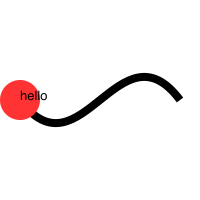

In [5]:
import math
svgio = BytesIO()
scale=200.0
with cairo.SVGSurface(svgio, 200, 200) as surface:
    
    
    # These lines are copied verbatim from the
    # pycairo page: https://pycairo.readthedocs.io
    context = cairo.Context(surface)
#     context.scale(scale, scale)
    context.set_line_width(0.04)
    x, y, x1, y1 = 0.1, 0.5, 0.4, 0.9
    x2, y2, x3, y3 = 0.6, 0.1, 0.9, 0.5
    context.set_line_width(0.04*scale)
    context.move_to(x*scale, y*scale)
    context.curve_to(x1*scale, y1*scale, x2*scale, y2*scale, x3*scale, y3*scale)
    context.stroke()
    context.set_source_rgba(1, 0.2, 0.2, 1)
    context.set_line_width(0.02*scale)
    context.stroke()
#     context.move_to(x, y)
#     context.line_to(x1, y1)
#     context.move_to(x2, y2)
#     context.line_to(x3, y3)
#     context.stroke()
    
    context.set_source_rgba(1, 0.2, 0.2, 1)
    context.arc(x*scale,y*scale,0.1*scale,0,math.tau)
    context.fill()
    context.set_source_rgba(0,0,0, 1)
#     context.select_font_face("Courier", cairo.FONT_SLANT_NORMAL, 
#         cairo.FONT_WEIGHT_NORMAL)
#     font_size=10
#     print(font_size)
    context.set_font_size(13)
    text="hello"
    (_, _, width, height, _, _) = context.text_extents(text) 
    context.move_to(x*scale-width/2, y*scale+height/2)
    context.move_to(x*scale,y*scale)
    context.show_text("hello")
    print(context.get_matrix().xx)
    # end of pycairo copy
IPython.display.SVG(data=svgio.getvalue())

In [293]:
None.__class__

NoneType

In [83]:
str(neat.edgedict[(0,2)])

'neatEdge{value_a:0 value_b:2 degree:1 angle:3.141592653589793 }'

In [85]:
(-1)%10

9

In [166]:
(not 0)+1

2

In [385]:
[0]+[1]

[0, 1]

In [433]:
print(*[1,2,3,4])

1 2 3 4


In [434]:
print(1,2,3,4)

1 2 3 4


In [446]:
def add(a,b,*argv):
    tot=a+b
    for val in argv:
        tot+=val
    return tot

In [447]:
add(1,2,3,4,5)

3


15

In [21]:
(1,2,3)[not 1]


1

In [20]:
[False,True]==[False,True]

True

In [49]:
math.ceil(0.6)

1

In [51]:
[1,2,3,4,5,6].index(3)

2

In [87]:

print(shift([1,2,4,5,6],-2))

[5, 6, 1, 2, 4]


In [59]:
[1,2,3].copy()

[1, 2, 3]

In [112]:
True if 1 else False

True